<a href="https://colab.research.google.com/github/OUBENSALAHNOURA/home-credit-groupe-4/blob/main/TP_deeplearning_classification_oubensalah_noura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip train.zip

In [ ]:
!unzip test.zip

In [ ]:
!unzip valid.zip

In [ ]:
!unzip lfw.zip

In [ ]:
import random
from keras.applications.resnet50 import ResNet50
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import ImageFile
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Lambda, ELU, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt                      
%matplotlib inline  

In [ ]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('train')
valid_files, valid_targets = load_dataset('valid')
test_files, test_targets = load_dataset('test')

# load list of dog names
dog_names = [item[10:-1] for item in sorted(glob("train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [ ]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 4s 0us/step


In [ ]:

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:


def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [ ]:

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [ ]:
                 
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 117.66it/s]


# CNN

In [ ]:
#from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
model = Sequential()



#model.add(Lambda(lambda x: (x/127.5) - 0.5))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# input for following code found here: https://keras.io/getting-started/sequential-model-guide/
# improved model accuracy dramatically
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))

### Defining the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [ ]:
#définir loss fonction et optimiser => définir le cout
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint  

epochs = 25



checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

In [ ]:
#télécharger les meilleurs poids
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [ ]:
#get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
#report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: {}'.format(12.2))

Test accuracy: 12.2


## Transfert learning

prendre les poinds de l'architucture déjà entrainé sur la classification des images 

In [ ]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('DogResnet50Data.npz')
train_Resnet = bottleneck_features['train']
valid_Resnet = bottleneck_features['valid']
test_Resnet = bottleneck_features['test']

In [ ]:
print(bottleneck_features)

ici on créé notre model avec des les couches de model pre entrainé DogResnet50Dat 

In [ ]:
### TODO: Define your architecture.
Resnet_Model = Sequential()

Resnet_Model.add(GlobalAveragePooling2D(input_shape=train_Resnet.shape[1:]))
Resnet_Model.add(Dense(133,activation='softmax'))

Resnet_Model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Définir la fonctio du cout
Resnet_Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet.hdf5', #télécharger les parametres
                               verbose=1, save_best_only=True)

Resnet_Model.fit(train_Resnet, train_targets, 
          validation_data=(valid_Resnet, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

In [ ]:
### TODO: Load the model weights with the best validation loss.
Resnet_Model.load_weights('saved_models/weights.best.Resnet.hdf5')

In [ ]:
Resnet_Model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf 

In [ ]:
tf.keras.models.save_model(Resnet_Model, "model")

INFO:tensorflow:Assets written to: model/assets


In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = tf.keras.models.load_model("model")

In [ ]:
help(Resnet_Model)

In [ ]:
### TODO: Calculate classification accuracy on the test dataset.
Resnet_Predictions = [np.argmax(Resnet_Model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet]

# Reporting Test Accuracy
test_accuracy = 100*np.sum(np.array(Resnet_Predictions)==np.argmax(test_targets, axis=1))/len(Resnet_Predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.1005%


In [ ]:
from extract_bottleneck_features import *
import numpy as np

In [ ]:
def extract_Resnet50(tensor):
	from keras.applications.resnet50 import ResNet50, preprocess_input
	return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [ ]:
def Resnet_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet_Model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def get_correct_prenom(word, vowels):
    if word[0].lower() in vowels:
            return "an"
    else:
        return "a"

def show_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = plt.imshow(cv_rgb)
    return img_display
def predict_image(img_path):
    vowels=["a","e","i","o","u"]
    show_img(img_path)
    #if a dog is detected in the image, return the predicted breed.
    if dog_detector(img_path)==True:
        predicted_breed=Resnet_predict_breed(img_path)
        prenom=get_correct_prenom(predicted_breed,vowels)
        return "The predicted dog breed is " + prenom + " "+ str(predicted_breed) + "."
    #if a human is detected in the image, return the resembling dog breed.
    if face_detector(img_path)==True:
        predicted_breed=Resnet_predict_breed(img_path)
        prenom=get_correct_prenom(predicted_breed,vowels)
        return "This photo looks like " + prenom + " "+ str(predicted_breed) + "."
    #if neither is detected in the image, provide output that indicates an error.
    else:
        return "No human or dog could be detected, please provide another picture."

'The predicted dog breed is an American_eskimo_dog.'

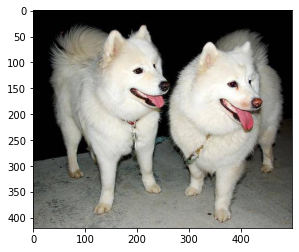

In [ ]:
predict_image("00102ee9d8eb90812350685311fe5890.jpg")